In [36]:
import gc
from tqdm import tqdm

import polars as pl

In [37]:
df = pl.read_parquet('../../Статья 3/Article 3 Data/posts/preprocessed.parquet')

In [124]:
df

index,author,id,timestamp,message,tickers,prices,n_comments,reactions,n_reactions,date_1,date_2,date_3,date_4,date_5,comment_1,comment_2,comment_3,comment_4,comment_5,stocks,futures,CHMF,GAZP,GMKN,LKOH,MOEX,NLMK,NVTK,PLZL,ROSN,SBER,SNGS,T,TATN
u32,str,str,datetime[μs],str,list[str],list[str],i64,list[str],i64,datetime[μs],datetime[μs],datetime[μs],datetime[μs],datetime[μs],str,str,str,str,str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
12994,"""Wolverine""","""4be53bd1-d3fe-4689-b642-a56a70…",2020-01-01 03:19:00,"""$GAZP с меня ндфл удержали поч…","[""GAZP""]","[""256,4₽−50,5%""]",10,"[""083b50db-7d1b-43a0-aae3-88a73e8c3c39?size=small""]",1,2020-01-01 06:14:00,2020-01-01 07:09:00,2020-01-01 07:52:00,2020-01-01 09:16:00,2020-01-01 09:19:00,"""Налоговый отчет скачай и посмо…","""А с меня ничего не удержали...…","""Печаль :(.""","""А мне в разделе "" о счете"" пов…","""Они сняли и сделали минус, где…",true,false,false,true,false,false,false,false,false,false,false,false,false,false,false
12995,"""TradeShark""","""eeb662fa-1751-4226-a641-dfb3d9…",2020-01-01 07:59:00,"""Футбольный портфель 💼 ⚽️ Спонс…","[""KZOS"", ""GAZP""]","[""105₽−22,38%"", ""256,4₽−51,52%""]",8,"[""083b50db-7d1b-43a0-aae3-88a73e8c3c39?size=small""]",24,2020-01-01 08:38:00,2020-01-01 10:37:00,2020-01-01 11:38:00,2020-01-01 12:45:00,2020-01-01 13:06:00,"""К слову Газпром также спонсиру…","""Рубин - казаньоргсинтез, НКНХ …","""@Mobbi диверсификация в действ…","""@ON_FLEEK_investing ок. Добави…","""Опасное это дело , связываться…",true,false,false,true,false,false,false,false,false,false,false,false,false,false,false
12996,"""strag9988""","""4a4fc534-9e8c-4ced-9207-0c0fe3…",2020-01-01 14:02:00,"""$TATN добрый вечер! Кто что ду…","[""TATN""]","[""759,7₽−24,85%""]",null,null,null,null,null,null,null,null,null,null,null,null,null,true,false,false,false,false,false,false,false,false,false,false,false,false,false,true
12997,"""wictor.rodionov""","""6ef14a3b-e24b-44f6-a903-4445da…",2020-01-01 14:09:00,"""Всем привет! Наконец-то я осм…","[""GAZP""]","[""256,4₽−48,94%""]",1,"[""083b50db-7d1b-43a0-aae3-88a73e8c3c39?size=small""]",2,2020-01-01 14:10:00,null,null,null,null,"""#YNDX""",null,null,null,null,true,false,false,true,false,false,false,false,false,false,false,false,false,false,false
12998,"""MOEX4Makson""","""32ee17de-289b-413b-8126-88d9ed…",2020-01-01 17:46:00,"""Итак, из того, что хотел взять…","[""MOEX"", ""SBERP""]","[""107,75₽+90,81%"", ""228,3₽+21,2%""]",3,"[""083b50db-7d1b-43a0-aae3-88a73e8c3c39?size=small""]",3,2020-01-02 02:45:00,2020-01-02 07:29:00,2020-01-02 07:50:00,null,null,"""А если не будет просадки в пер…","""@Mobbi, ну что ж поделать, буд…","""Порт тоже покупал регулярно, д…",null,null,true,false,false,false,false,false,true,false,false,false,false,true,false,false,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
783550,"""Fin79rus""","""723cd320-3f30-44de-ac37-801a1e…",2025-04-13 17:13:00,"""Обзор дивидендов Полюс • 2019…","[""PLZL""]","[""1 924,8₽−1,4%""]",null,"[""083b50db-7d1b-43a0-aae3-88a73e8c3c39?size=small"", ""4f7537b2-627f-4142-ba73-203ac294cd08?size=small"", ""c53ba585-196d-48eb-a463-8d7fd3d6d141?size=small""]",5,null,null,null,null,null,null,null,null,null,null,true,false,false,false,false,false,false,false,false,true,false,false,false,false,false
783551,"""novar""","""587e1a1e-fdd2-4580-aea2-2ce2c2…",2025-04-13 17:14:00,"""$TATN В панидельник немного пд…","[""TATN""]","[""695,6₽−1,84%""]",1,"[""083b50db-7d1b-43a0-aae3-88a73e8c3c39?size=small"", ""de2cafb6-f206-43b2-bd9a-8f9d80048f04?size=small""]",2,2025-04-13 18:02:00,null,null,null,null,"""могут дать 715""",null,null,null,null,true,false,false,false,false,false,false,false,false,false,false,false,false,false,true
783552,"""Long07""","""173e8f6d-a6f8-448c-b6b7-a143f5…",2025-04-13 17:16:00,"""$T Что думаете может ли на Пас…","[""T""]","[""3 190₽−0,56%""]",null,null,null,null,null,null,null,null,null,null,null,null,null,true,false,

In [39]:
companies = [['CHMF'], ['GAZP'], ['GMKN'], ['LKOH'], ['MOEX'], ['NLMK'], ['NVTK'], ['PLZL'], ['ROSN'], ['SBER', 'SBERP'], ['SNGS', 'SNGSP'],
             ['T'], ['TATN', 'TATNP'], ['X5', 'FIVE', 'FIVE@GS'], ['YDEX', 'YNDX', 'YNDX@US']]

company_names = [c[0] for c in companies]

futures = [['CH'], ['GZ', 'GAZPF'], ['GK'], ['LK'], ['MX'], ['NM'], ['NK'], ['PX'], ['RN'], ['SBERF', 'SR', 'SP'], ['SN', 'SG'],
            ['TB'], ['ТТ', 'TP'], ['X5'], ['YD', 'YA']]

In [109]:
def split_by_companies(df: pl.DataFrame, companies, futures):
    agg_df = []
    for company in companies:
        for ticker in company:
            tmp = df.filter(pl.col('tickers').list.contains(ticker)).with_columns(pl.lit(True).alias('stocks'),
                                                                                    *[pl.lit(True).alias(name) if company[0]==name else pl.lit(False).alias(name) for name in company_names])
            agg_df.append(tmp)

    for future, company in zip(futures, companies):
        for ticker in future:
            pattern = f'^({ticker})[HMUZ]\\d$'
            tmp = df.filter(
                pl.col('tickers').list.eval(pl.element().str.contains(pattern)).list.any()
                ).with_columns(pl.lit(False).alias('stocks'),
                               *[pl.lit(True).alias(name) if company[0]==name else pl.lit(False).alias(name) for name in company_names])
            agg_df.append(tmp)

    agg_df = pl.concat(agg_df).with_columns(
        (pl.col("stocks") == False).alias("futures")
        )
    
    agg_df = agg_df.group_by([col for col in agg_df.columns if col not in ["stocks", "futures"]]).agg([
        pl.max("stocks").alias("stocks"),
        pl.max("futures").alias("futures")
        ])

    base_columns = [col for col in agg_df.columns if col not in ["stocks", "futures"] + company_names]

    agg_df = agg_df.group_by(base_columns).agg([
        pl.col("stocks").max().alias("stocks"),
        pl.col("futures").max().alias("futures"),
        *[pl.col(company).max().alias(company) for company in company_names]
    ]).unique('message').sort('timestamp')

    return agg_df

In [110]:
agg_df = split_by_companies(df, companies, futures)

In [ ]:
agg_df.write_parquet('../data/texts/filtered_comments.parquet')

# EDA и фильтрации

In [42]:
import datetime

import numpy as np
import polars as pl
import matplotlib.pyplot as plt

In [ ]:
df = pl.read_parquet('../data/texts/filtered_comments.parquet')

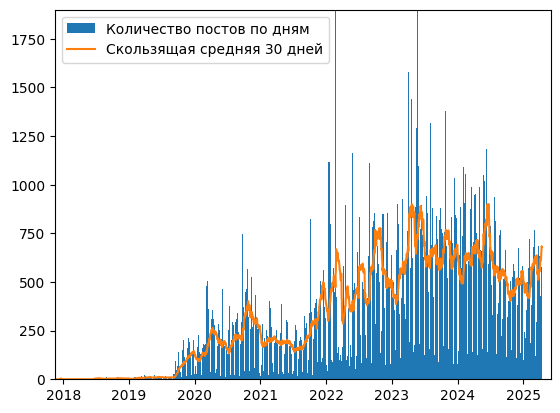

In [44]:
fig = plt.hist(df['timestamp'], bins=len(df['timestamp'].dt.date().unique()), label='Количество постов по дням')
window_size = 30
weights = np.ones(window_size) / window_size
running_mean = np.convolve(fig[0], weights, mode='valid')
running_mean = np.concatenate([np.zeros(len(fig[1]) - len(running_mean), running_mean[-1]), running_mean])
plt.plot(fig[1], running_mean, label='Скользящая средняя 30 дней')
plt.ylim(0, 1900)
plt.xlim(fig[1][0], fig[1][-1]+50)
plt.legend()
plt.show()

In [45]:
df = df.with_row_index().filter(pl.col('timestamp') >= datetime.date(2020, 1, 1))

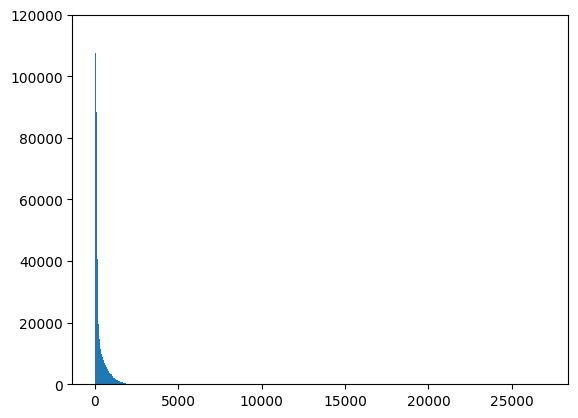

In [46]:
plt.hist(df['message'].str.len_chars(), bins=1000)
plt.ylim(0, 120_000)
plt.show()

In [47]:
df = df.filter(pl.col('message').str.len_chars() <= pl.col('message').str.len_chars().quantile(0.99))

In [48]:
for name in company_names:
    print(name, len(df.filter(pl.col(name)==True)))

CHMF 29703
GAZP 191801
GMKN 31963
LKOH 60765
MOEX 46198
NLMK 21254
NVTK 31321
PLZL 31247
ROSN 42529
SBER 167268
SNGS 31742
T 85636
TATN 43073
X5 2721
YDEX 8502


In [ ]:
df = df.filter(~((pl.col('YDEX') == True) &
               (pl.sum_horizontal([pl.col(company) for company in company_names[:-2]]) == 0)))

df = df.filter(~((pl.col('X5') == True) &
               (pl.sum_horizontal([pl.col(company) for company in company_names[:-2]]) == 0)))

df = df.drop(['YDEX', 'X5'])

In [63]:
embs = np.load('../data/dataset.npy')

In [66]:
embs = embs[df['index'].to_numpy()]

In [68]:
np.save('../data/dataset.npy', embs)

In [ ]:
df.write_parquet('../data/texts/final_comments.parquet')

# Продолжение EDA на отфильтрованном датасете

In [122]:
import polars as pl
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
df = pl.read_parquet('../data/texts/final_comments.parquet')

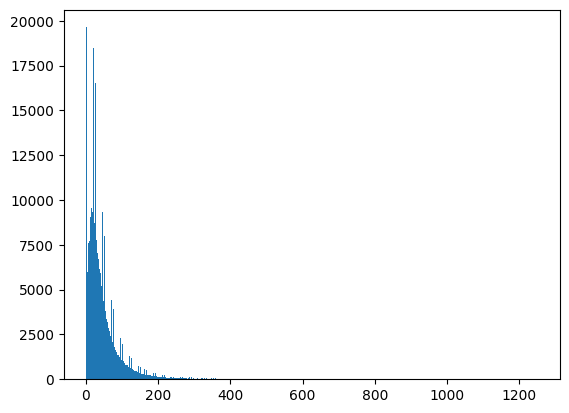

In [86]:
plt.hist(df['comment_1'].str.len_chars(), bins=1000)
plt.show()

In [101]:
for i in range(1, 6):
    print(df[f'comment_{i}'].is_not_null().sum())

534828
441323
360520
298910
247133


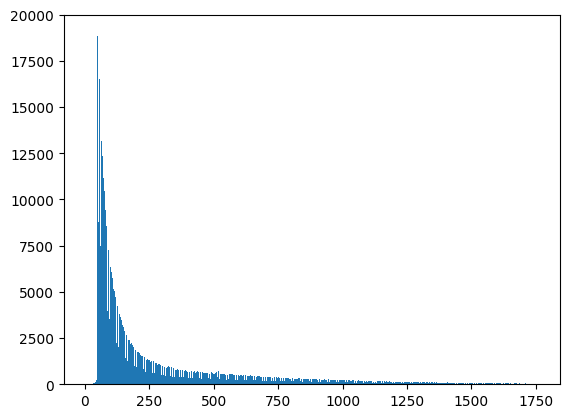

In [103]:
plt.hist(df['message'].str.len_chars(), bins=1000)
plt.ylim(0, 20_000)
plt.show()

# Обработка временных тиков

In [15]:
import os
from tqdm import tqdm

import polars as pl
import numpy as np

In [2]:
companies = ['CHMF', 'GAZP', 'GMKN', 'LKOH', 'MOEX', 'NLMK', 'NVTK', 'PLZL', 'ROSN', 'SBER', 'SNGS', 'T', 'TATN']

In [35]:
for company in tqdm(companies):
    files = [f for f in os.listdir('../data/time_series') if company == f[:-18] and '.csv' in f]
    df = []
    for file in files:
        tmp = pl.read_csv(f'../data/time_series/{file}', separator=';').drop(['<TICKER>', '<PER>'])
        tmp = tmp.with_columns(('20' + pl.col('<DATE>').cast(str) + \
                                pl.when(pl.col('<TIME>').cast(str).str.len_chars() < 6)
                                .then('0' + pl.col('<TIME>').cast(str))
                                .otherwise(pl.col('<TIME>').cast(str))).str.to_datetime('%Y%m%d%H%M%S').alias('datetime'))
        tmp = tmp.drop(['<DATE>', '<TIME>']).rename({'<OPEN>': 'open', '<HIGH>': 'high', '<LOW>': 'low',
                                                     '<CLOSE>': 'close', '<VOL>': 'vol'})
        df.append(tmp)
    df = pl.concat(df).sort('datetime')
    df.write_parquet(f'../data/time_series/{file.split('_')[0]}.parquet')

100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


In [42]:
pl.read_parquet('../data/time_series/PLZL.parquet')

open,high,low,close,vol,datetime
f64,f64,f64,f64,i64,datetime[μs]
717.7,721.0,717.0,720.95,21590,2020-01-03 10:00:00
720.85,722.25,720.35,720.5,4730,2020-01-03 10:01:00
720.6,720.6,719.0,719.0,8690,2020-01-03 10:02:00
719.1,721.45,719.0,720.0,7210,2020-01-03 10:03:00
720.45,720.9,720.1,720.2,2370,2020-01-03 10:04:00
…,…,…,…,…,…
1751.4,1752.8,1751.2,1752.8,209,2025-04-30 23:45:00
1752.6,1752.8,1751.2,1751.8,350,2025-04-30 23:46:00
1751.8,1751.8,1751.6,1751.6,21,2025-04-30 23:47:00


# Обработка временных рядов

In [65]:
import os
import polars as pl

In [66]:
companies = ['CHMF', 'GAZP', 'GMKN', 'LKOH', 'MOEX', 'NLMK', 'NVTK', 'PLZL', 'ROSN', 'SBER', 'SNGS', 'T', 'TATN']

In [69]:
for company in companies:
    df = pl.read_parquet(f'../data/time_series/raw/{company}.parquet')
    tmp = df.with_columns(((pl.col('open') + pl.col('high') + pl.col('low') + pl.col('close')) / 4 * pl.col('vol')).alias('vol_rub')).group_by(pl.col('datetime').dt.date().alias('date')).agg(
        (pl.col('vol_rub').sum() / pl.col('vol').sum()).alias('weighted_1d'), pl.col('open').first().alias('open'), pl.col('close').last().alias('close'), pl.col('high').max().alias('high'), pl.col('low').min().alias('low')).sort('date')
    tmp = tmp.with_columns((pl.col('weighted_1d') / pl.col('weighted_1d').shift(1) - 1).alias('diff_weighted_1d'),
                           (pl.col('open') / pl.col('open').shift(1) - 1).alias('diff_open_1d'),
                           (pl.col('close') / pl.col('close').shift(1) - 1).alias('diff_close_1d'),
                           (pl.col('high') / pl.col('high').shift(1) - 1).alias('diff_high_1d'),
                           (pl.col('low') / pl.col('low').shift(1) - 1).alias('diff_low_1d'))
    tmp.write_parquet(f'../data/time_series/preprocessed/{company}_1d.parquet')

In [70]:
pl.read_parquet(f'../data/time_series/preprocessed/T_1d.parquet')

date,weighted_1d,open,close,high,low,diff_weighted_1d,diff_open_1d,diff_close_1d,diff_high_1d,diff_low_1d
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2020-01-03,1344.081686,1317.2,1332.4,1353.0,1317.2,null,null,null,null,null
2020-01-06,1321.266081,1339.8,1322.8,1349.4,1312.0,-0.016975,0.017158,-0.007205,-0.002661,-0.003948
2020-01-08,1334.389802,1315.2,1350.2,1350.2,1312.4,0.009933,-0.018361,0.020714,0.000593,0.000305
2020-01-09,1357.582184,1350.2,1366.8,1368.0,1333.8,0.017381,0.026612,0.012294,0.013183,0.016306
2020-01-10,1381.384168,1370.0,1398.4,1401.0,1355.0,0.017533,0.014664,0.02312,0.024123,0.015894
…,…,…,…,…,…,…,…,…,…,…
2025-04-26,3324.231219,3301.6,3314.8,3347.8,3300.4,0.018224,0.025278,0.009256,0.017878,0.024969
2025-04-27,3324.531384,3324.0,3324.4,3330.0,3317.2,0.00009,0.006785,0.002896,-0.005317,0.00509
2025-04-28,3302.634106,3319.8,3279.8,3331.8,3268.0,-0.006587,-0.001264,-0.013416,0.000541,-0.014832


# Обработка полученных эмбеддингов

In [2]:
import os
import gc
from tqdm import tqdm

import polars as pl
import numpy as np

In [7]:
cols = ['message', *[f'comment_{i}' for i in range(1, 6)]]
companies = ['CHMF', 'GAZP', 'GMKN', 'LKOH', 'MOEX', 'NLMK', 'NVTK', 'PLZL', 'ROSN', 'SBER', 'SNGS', 'T', 'TATN']

df = pl.read_parquet('../data/texts/final_comments.parquet')

In [8]:
def prep_embeddings(naming=''):
    for col in tqdm(cols):
        embs = np.load(f'../data/embeddings/raw/{naming}/{col}.npy')
        for company in companies:
            tmp = df.drop_nulls(col).with_row_index('i').filter(pl.col(company) == True)
            tmp_embs = embs[tmp['i'].to_list()]
            pl_embs = pl.from_numpy(tmp_embs)
            tmp = pl.concat([tmp, pl_embs], how='horizontal')
            tmp = tmp.group_by(pl.col('timestamp').dt.date().alias('date')).agg(*[pl.col(f'column_{i}').mean() for i in range(tmp_embs.shape[1])]).sort('date').drop_nulls()
            tmp.write_parquet(f'../data/embeddings/preprocessed/{naming}/{col}_{company}.parquet')

In [9]:
prep_embeddings('vk')
prep_embeddings('giga')

100%|██████████| 6/6 [02:29<00:00, 24.97s/it]


# Соотносим торговые данные и эмбеддинги

In [10]:
import os
import gc
from tqdm import tqdm

import polars as pl
import matplotlib.pyplot as plt

In [11]:
companies = ['CHMF', 'GAZP', 'GMKN', 'LKOH', 'MOEX', 'NLMK', 'NVTK', 'PLZL', 'ROSN', 'SBER', 'SNGS', 'T', 'TATN']

In [12]:
def get_final_dataset(naming):
    for company in tqdm(companies):
        df = pl.read_parquet(f'../data/time_series/preprocessed/{company}_1d.parquet')
        embs = pl.read_parquet(f'../data/embeddings/preprocessed/{naming}/message_{company}.parquet')
        df = embs.join(df, on='date', how='left')
        emb_cols = [col for col in df.columns if 'column' in col]
        df = df.with_columns([pl.col(col) for col in emb_cols])

        df_with_flags = df.with_columns(
            pl.col('diff_weighted_1d').is_not_null().alias('is_trading_day')
        )

        df_with_last_trading = df_with_flags.with_columns(
            pl.when(pl.col('is_trading_day'))
            .then(pl.col('date'))
            .otherwise(None)
            .backward_fill()
            .alias('last_trading_day')
        )

        avg_embeddings = (
            df_with_last_trading
            .group_by('last_trading_day')
            .agg(*[pl.col(col).mean() for col in emb_cols])
            .sort('last_trading_day')
            )
        
        df.drop(emb_cols).join(avg_embeddings, left_on='date', right_on='last_trading_day').write_parquet(f'../data/final/{naming}/{company}.parquet')

In [13]:
get_final_dataset('vk')
get_final_dataset('giga')

100%|██████████| 13/13 [00:02<00:00,  4.50it/s]


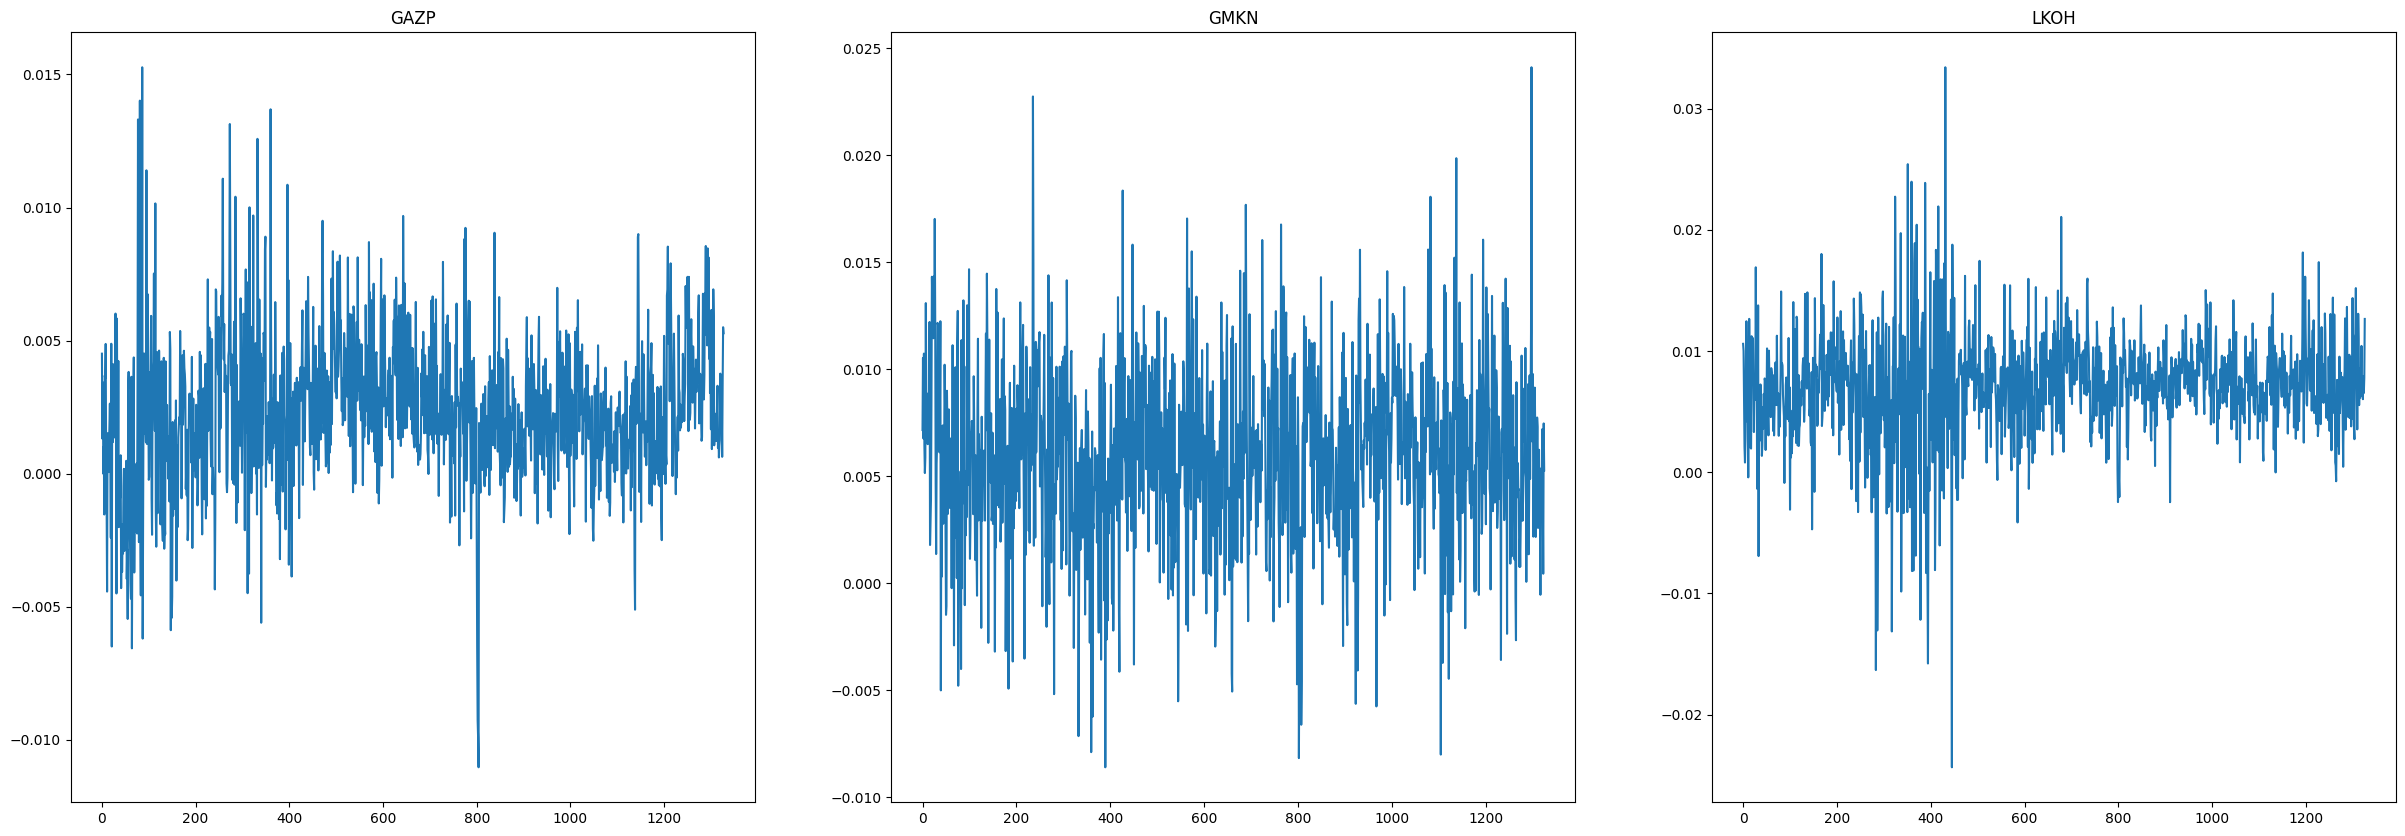

In [14]:
naming = 'giga'
i = 200
comps = companies[1:4]
fig, axs = plt.subplots(1, len(comps), figsize=(30,10))
for ax, comp in zip(axs.ravel(), comps):
    df = pl.read_parquet(f'../data/final/{naming}/{comp}.parquet')
    ax.plot(df[f'column_{i}'])
    ax.set_title(comp)
plt.show()